# Measuring Engagement and Satisfaction in Online Mental Health Platform Conversations

## Data preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from math import log10, floor
import math

In [ ]:
# Display long column text
pd.options.display.max_colwidth = 500

df = pd.read_csv("mentalhealthsupport_dyadic_convs_clean_emotion.csv")
df = df.rename(columns={'conversation id': 'conversation_id', 'post title': 'post_title', 'dialog turn': 'dialog_turn', 'emotion prediction': 'emotion_prediction'})

In [78]:
### --- CLEANING OUT MONOLOGUES FROM DATASET --- ###

# Group data by conversation id and calculate count of each conversation id
df_conv = df.groupby("conversation_id").count()
df_conv = df_conv.drop(columns=["subreddit", "post_title", "author", "text", "compound", "sentiment", "emotion_prediction"])
print("Number of conversations in subreddit: ", len(df_conv))

# Separate conversation id's with a single occurrence as monologues
df_mono = df_conv[df_conv["dialog_turn"] == 1]
print("Number of monologues in subreddit: ", len(df_mono))
df_mono_ids = df_mono.reset_index()
df_mono_ids = df_mono_ids["conversation_id"]

# Separate conversation id's with multiple occurrences as dialogues
df_dia = df_conv[df_conv["dialog_turn"] > 2]
print("Number of dialogues longer than 2 turns in subreddit: ", len(df_dia))
df_dia = df_dia.reset_index()
df_dia = df_dia.drop(columns=['dialog_turn'])

# Join dialogue conversation id's with original data such that only dialogues remain in the dataset
df = df.join(df_dia.set_index('conversation_id'), on='conversation_id', how="right") 

# TODO: possibly remove single interaction conversations too as we cannot determine satisfaction

### ---------------------------------------------- ###

Number of conversations in subreddit:  3551
Number of monologues in subreddit:  29
Number of dialogues in subreddit:  487


In [79]:
# Round numbers to a given number of significant figures (default = 2)
def round_sig(x, sig=2):
    if x != 0:
        return round(x, sig-int(floor(log10(abs(x))))-1)
    else:
        return

## Measuring the level of engagement

### Does the speaker respond back when the listener gives a response?

In [80]:
def extract_responses(conversation):
    speaker = conversation.author.iloc[0]
    listener = conversation[conversation["author"] != speaker]["author"].unique().item() 
    speaker_responses = conversation[conversation["author"] == speaker]
    listener_responses = conversation[conversation["author"] == listener]
    num_speaker_responses = len(speaker_responses)
    num_listener_responses = len(listener_responses)
    
    return speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses

In [81]:
def calculate_speaker_listener_ratio():
    speaker_listener_ratio = num_speaker_responses / num_listener_responses
    
    engagement = ""
    if len(conversation) == 2:
        engagement = "low engagement" # single interaction
    elif len(conversation) == 3:
        if speaker_listener_ratio == 2: 
            engagement = "low engagement" # repeated seeker interaction)
        else: #speaker_listener_ratio == 0.5: 
            engagement = "low engagement" # repeated peer supporter interaction
    elif len(conversation) == 4:
        if speaker_listener_ratio == 1:
            engagement = "high engagement" # TODO: ask if 4 is enough to classify as high engagement b/c Sharma et. al. classifies it as mutual discourse
        elif speaker_listener_ratio == 3 or speaker_listener_ratio == (1/3):
            engagement = "low engagement"
    elif len(conversation) > 4:
        if speaker_listener_ratio >= 0.75 and speaker_listener_ratio <= 1.25:
            engagement = "high engagement"
        elif speaker_listener_ratio <= 0.5 or speaker_listener_ratio >= 1.5:
            engagement = "low engagement"
        else:
            engagement = "moderate engagement"
        
    return round_sig(speaker_listener_ratio), engagement

### Does the listener ask any informative questions or give any suggestions? 

Unfortunately, the emotion predictions are very inaccurate. Normally, we could have given bonus points to questioning and/or suggesting listener responses. 

In [82]:
# TODO: separately label each & every sentence, currently only the whole text is labeled

### How the literature measures engagement

## Measuring the level of satisfaction

### Lexical details: "Thank you", "It means a lot"

### Shift of sentiment in speaker responses (sentiment trend)

In [83]:
def plot_emotion_sentiment():   
    sns.set_theme(style="white")
    g = sns.relplot(x="dialog_turn", y="compound", hue="sentiment", style="emotion_prediction", palette="Set1",data=speaker_responses, s=200)
    g.fig.suptitle('Sentimental and Emotional Shift in Speaker Responses with Conversation Progression', fontsize=16)
    g.fig.subplots_adjust(top=0.9);

In [98]:
# TODO: check if r^2 is actually a good measure for this
def calculate_sentiment_shift():
    satisfaction = ""
    
    x = np.array(speaker_responses["dialog_turn"]).reshape((-1, 1))
    y = np.array(speaker_responses["compound"])
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    
    grateful_bonus = check_grateful_positive()
    r_sq += grateful_bonus
    
    if len(conversation) == 2:
        satisfaction = "none"
        r_sq = 0
    
    else:
        if r_sq >= 0.6: # TODO: play with these variables (maybe even do some ML to learn these params)
            satisfaction = "positive satisfaction"
        elif r_sq >= 0.4:
            satisfaction = "moderate satisfaction"
        elif r_sq < 0.4 and r_sq >= 0.3:
            satisfaction = "neutral satisfaction"
        elif r_sq < 0.3:
            satisfaction = "negative satisfaction"
            
    return round_sig(r_sq), satisfaction, grateful_bonus

### If the last speaker turn has grateful emotion and has positive sentiment

In [85]:
# Get all emotions and the final emotion of the given responses
def get_emotion_prediction():
    emotions = speaker_responses["emotion_prediction"]
    final_emotion = emotions.iloc[-1]
    
    return emotions, final_emotion

In [86]:
# Get all sentiments and the final sentiment of the given responses
def get_sentiment():
    sentiments = speaker_responses["sentiment"]
    final_sentiment = sentiments.iloc[-1]
    
    return sentiments, final_sentiment

In [87]:
# Add bonus points if the last speaker post is grateful and has positive sentiment
def check_grateful_positive():
    _, final_sentiment = get_sentiment()
    _, final_emotion = get_emotion_prediction()
    
    grateful_bonus=0
    
    if final_sentiment == "positive" and final_emotion == "grateful":
        grateful_bonus += 0.1
    
    return grateful_bonus

### How the literature measures satisfaction

## Final classification

In [88]:
def classify_conversation(conversation):
    return str(calculate_speaker_listener_ratio()[1] + ", " + calculate_sentiment_shift()[1])

## Testing the measures

In [89]:
def test_examples(conversation_id):
    plot_emotion_sentiment()
    print("Conversation length: ", len(conversation))
    print("Engagement coefficient: ", calculate_speaker_listener_ratio()[0], " --> ", calculate_speaker_listener_ratio()[1])
    print("Sentiment coefficient: ", calculate_sentiment_shift()[0], " with grateful bonus: ", calculate_sentiment_shift()[2], " --> ", calculate_sentiment_shift()[1])
    print("Classification summary: ", classify_conversation(conversation))

In [95]:
# Get a random conversation to test on from either short or long conversations
long_conversations = df[df["dialog_turn"] >= 6]["conversation_id"].unique()
short_conversations = df[df["dialog_turn"] < 6]["conversation_id"].unique()

num = int(input("Enter order number of long conversation: "))
conversation_id = df[df["conversation_id"] == short_conversations[num]]["conversation_id"]
conversation_id = conversation_id.iloc[0]
print("Chosen conversation id: ", conversation_id)
conversation = df[df["conversation_id"] == conversation_id]
speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses = extract_responses(conversation)

Enter order number of long conversation:  10


Chosen conversation id:  56


Conversation length:  3
Engagement coefficient:  2.0  -->  low engagement
Sentiment coefficient:  1.0  with grateful bonus:  0  -->  positive satisfaction
Classification summary:  low engagement, positive satisfaction


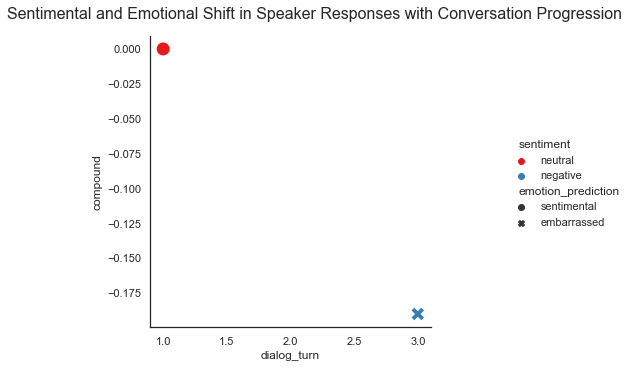

In [96]:
test_examples(conversation_id)

In [97]:
conversation

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
125,56,MentalHealthSupport,histrionic personality disorder,anuspain420,1,"haven't seen any posts about it on here, wondering here if anyone else has it? ;^^",0.0000,neutral,sentimental
126,56,MentalHealthSupport,histrionic personality disorder,berry_cherry,2,I've never met anyone who has been diagnosed with HPD actually. Even online I don't see people talk about it very much. I have definitely met people who fit the symptoms (in my mind) but even all the treatment I've been in I've never met someone who admitted to be dx'd with HPD. Do you have it? What is it like? What are your symptoms? I am very interested in it and I actually kind of suspect my sister has it or NPD.,0.8290,positive,lonely
127,56,MentalHealthSupport,histrionic personality disorder,anuspain420,3,"Not professionally diagnosed, so no. But I do assume I have it seeing I fit the criteria for it. It's pretty awful considering you have to have the spotlight on you all the time, and then people are mad at you because you don't understand that they can't have attention from others.",-0.1901,negative,embarrassed


In [ ]:
test_examples(1003)

In [ ]:
df[df.conversation_id == 1003]

In [ ]:
test_examples(1732)

In [ ]:
test_examples(1754)

## Emotion prediction is not accurate at all...

In [ ]:
conversation_bad_emotion_prediction_example = df[df["conversation_id"] == 1754]
conversation_bad_emotion_prediction_example

When we check the emotion predictions, we see that most of them are very inaccurate. The sentiment tags are more accurate.

In [ ]:
df[df["emotion_prediction"]=="questioning"]

In [ ]:
print(df[(df["conversation_id"]==342) & (df["dialog_turn"]==4)]["text"])
print(df[(df["conversation_id"]==455) & (df["dialog_turn"]==2)]["text"])
print(df[(df["conversation_id"]==578) & (df["dialog_turn"]==2)]["text"])
print(df[(df["conversation_id"]==1761) & (df["dialog_turn"]==2)]["text"])
print(df[(df["conversation_id"]==2414) & (df["dialog_turn"]==2)]["text"])

The questioning tags are not accurate either. Only one of the statements that are tagged with the questioning tag are actually questioning.

In [ ]:
df[df["emotion_prediction"]=="suggesting"]

There are no posts with a suggesting tag in this subreddit. Therefore, it cannot be utilized in the calculation of the engagement measure.